In [1]:
from google.colab import drive
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten, Dense, Lambda, BatchNormalization, Dropout, GlobalAveragePooling2D, Concatenate, Activation, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

# Mount Google Drive
drive.mount('/content/drive')

# Load the labels
labels_path = '/content/drive/MyDrive/Contrastive Learning/contrastive_learning_labels.csv'
labels_df = pd.read_csv(labels_path)

# Directory path where images are stored
image_dir = '/content/drive/MyDrive/Contrastive Learning/contrastive_learning_images'

# Check if the image directory exists
if not os.path.exists(image_dir):
    print("Image directory not found!")
else:
    print("Images are ready for training.")

Mounted at /content/drive
Images are ready for training.


# Modelling

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50

def load_image(pothole_id, directory, target_size=(224, 224)):
    img_path = os.path.join(directory, f'{pothole_id}.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

def data_generator(save_dir, batch_size=32, is_validation=False):
    pairs_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('pairs_batch_') and f.endswith('.npy')])
    scalar_features_1_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_1_batch_') and f.endswith('.npy')])
    scalar_features_2_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_2_batch_') and f.endswith('.npy')])
    labels_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('labels_batch_') and f.endswith('.npy')])

    if is_validation:
        # Use the last 20% of batches for validation
        validation_start = int(0.8 * len(pairs_batches))
        pairs_batches = pairs_batches[validation_start:]
        scalar_features_1_batches = scalar_features_1_batches[validation_start:]
        scalar_features_2_batches = scalar_features_2_batches[validation_start:]
        labels_batches = labels_batches[validation_start:]
    else:
        # Use the first 80% of batches for training
        validation_end = int(0.8 * len(pairs_batches))
        pairs_batches = pairs_batches[:validation_end]
        scalar_features_1_batches = scalar_features_1_batches[:validation_end]
        scalar_features_2_batches = scalar_features_2_batches[:validation_end]
        labels_batches = labels_batches[:validation_end]

    while True:
        for pair_file, sf1_file, sf2_file, label_file in zip(pairs_batches, scalar_features_1_batches, scalar_features_2_batches, labels_batches):
            pairs = np.load(os.path.join(save_dir, pair_file))
            scalar_features_1 = np.load(os.path.join(save_dir, sf1_file))
            scalar_features_2 = np.load(os.path.join(save_dir, sf2_file))
            labels = np.load(os.path.join(save_dir, label_file))

            num_batches = len(pairs) // batch_size
            for i in range(num_batches):
                batch_pairs = pairs[i*batch_size:(i+1)*batch_size]
                batch_sf1 = scalar_features_1[i*batch_size:(i+1)*batch_size]
                batch_sf2 = scalar_features_2[i*batch_size:(i+1)*batch_size]
                batch_labels = labels[i*batch_size:(i+1)*batch_size]

                yield (
                    (
                        tf.convert_to_tensor(batch_pairs[:, 0], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf1, dtype=tf.float32),
                        tf.convert_to_tensor(batch_pairs[:, 1], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf2, dtype=tf.float32)
                    ),
                    tf.convert_to_tensor(batch_labels, dtype=tf.float32)
                )

def make_embedding_model_with_scalars(input_shape=(224, 224, 3), scalar_shape=(2,), embedding_dim=64):
    # Load the ResNet50 model, excluding the top layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True

    # Add global average pooling layer
    f1 = GlobalAveragePooling2D()(base_model.output)
    f1 = Dropout(0.5)(f1)

    # Scalar input branch
    scalar_input = Input(shape=scalar_shape, name='input_scalar')

    # Combine image features and scalar features
    combined = Concatenate()([f1, scalar_input])

    # Add a fully connected layer for embedding
    embedding = Dense(embedding_dim, activation='relu')(combined)
    embedding = BatchNormalization()(embedding)

    # Define the final model
    return Model([base_model.input, scalar_input], embedding, name='embedding_model')

def create_contrastive_model(input_shape=(224, 224, 3), scalar_shape=(2,), embedding_dim=128):
    embedding_model = make_embedding_model_with_scalars(input_shape=input_shape, scalar_shape=scalar_shape, embedding_dim=embedding_dim)

    input_a = Input(shape=input_shape, name='input_img_a')
    input_b = Input(shape=input_shape, name='input_img_b')

    scalar_input_a = Input(shape=scalar_shape, name='input_scalar_a')
    scalar_input_b = Input(shape=scalar_shape, name='input_scalar_b')

    embedding_a = embedding_model([input_a, scalar_input_a])
    embedding_b = embedding_model([input_b, scalar_input_b])

    distance = Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)),
                      name='distance')([embedding_a, embedding_b])

    contrastive_model = Model(inputs=[input_a, scalar_input_a, input_b, scalar_input_b], outputs=distance)

    return contrastive_model

class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        positive_pairs = y_true * tf.square(y_pred)
        negative_pairs = (1 - y_true) * tf.square(tf.maximum(self.margin - y_pred, 0))
        return tf.reduce_mean(positive_pairs + negative_pairs)

contrastive_model = create_contrastive_model()

contrastive_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=ContrastiveLoss(margin=0.5))

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Contrastive Learning/best_contrastive_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Adjust the datasets and remove the batch operation here, batching is done later
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32, is_validation=False),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32),            # Scalar features A
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32)             # Scalar features B
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32, is_validation=True),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32),            # Scalar features A
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32)             # Scalar features B
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

# Compile and train the model
history = contrastive_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    steps_per_epoch=100,
    validation_steps=20,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

KeyboardInterrupt: 

# Modelling -> Without Validation Set

In [ ]:
def load_image(pothole_id, directory, target_size=(224, 224)):
    img_path = os.path.join(directory, f'{pothole_id}.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

def data_generator(save_dir, batch_size=32):
    pairs_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('pairs_batch_') and f.endswith('.npy')])
    scalar_features_1_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_1_batch_') and f.endswith('.npy')])
    scalar_features_2_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_2_batch_') and f.endswith('.npy')])
    labels_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('labels_batch_') and f.endswith('.npy')])

    while True:
        for pair_file, sf1_file, sf2_file, label_file in zip(pairs_batches, scalar_features_1_batches, scalar_features_2_batches, labels_batches):
            pairs = np.load(os.path.join(save_dir, pair_file))
            scalar_features_1 = np.load(os.path.join(save_dir, sf1_file))
            scalar_features_2 = np.load(os.path.join(save_dir, sf2_file))
            labels = np.load(os.path.join(save_dir, label_file))

            num_batches = len(pairs) // batch_size
            for i in range(num_batches):
                batch_pairs = pairs[i*batch_size:(i+1)*batch_size]
                batch_sf1 = scalar_features_1[i*batch_size:(i+1)*batch_size]
                batch_sf2 = scalar_features_2[i*batch_size:(i+1)*batch_size]
                batch_labels = labels[i*batch_size:(i+1)*batch_size]

                yield (
                    (
                        tf.convert_to_tensor(batch_pairs[:, 0], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf1, dtype=tf.float32),
                        tf.convert_to_tensor(batch_pairs[:, 1], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf2, dtype=tf.float32)
                    ),
                    tf.convert_to_tensor(batch_labels, dtype=tf.float32)
                )

def make_simple_embedding_model_with_scalars(input_shape=(224, 224, 3), scalar_shape=(2,), embedding_dim=64):
    img_input = Input(shape=input_shape, name='input_image')

    # Simplified CNN layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    # Scalar input branch
    scalar_input = Input(shape=scalar_shape, name='input_scalar')

    # Combine image features and scalar features
    combined = Concatenate()([x, scalar_input])

    # Add a fully connected layer for embedding
    embedding = Dense(embedding_dim, activation='relu')(combined)
    embedding = BatchNormalization()(embedding)

    # Define the final model
    return Model([img_input, scalar_input], embedding, name='embedding_model')

def create_contrastive_model(input_shape=(224, 224, 3), scalar_shape=(2,), embedding_dim=64):
    embedding_model = make_simple_embedding_model_with_scalars(input_shape=input_shape, scalar_shape=scalar_shape, embedding_dim=embedding_dim)

    input_a = Input(shape=input_shape, name='input_img_a')
    input_b = Input(shape=input_shape, name='input_img_b')

    scalar_input_a = Input(shape=scalar_shape, name='input_scalar_a')
    scalar_input_b = Input(shape=scalar_shape, name='input_scalar_b')

    embedding_a = embedding_model([input_a, scalar_input_a])
    embedding_b = embedding_model([input_b, scalar_input_b])

    distance = Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)),
                      name='distance')([embedding_a, embedding_b])

    contrastive_model = Model(inputs=[input_a, scalar_input_a, input_b, scalar_input_b], outputs=distance)

    return contrastive_model

class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        positive_pairs = y_true * tf.square(y_pred)
        negative_pairs = (1 - y_true) * tf.square(tf.maximum(self.margin - y_pred, 0))
        return tf.reduce_mean(positive_pairs + negative_pairs)

# Create and compile the simplified contrastive model
contrastive_model = create_contrastive_model()

contrastive_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=ContrastiveLoss(margin=0.5))

# Remove validation and train for 50 epochs
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32),            # Scalar features A
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32)             # Scalar features B
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

# Train the model
history = contrastive_model.fit(
    train_dataset,
    epochs=50,
    steps_per_epoch=100,
    callbacks=[
        ModelCheckpoint('/content/drive/MyDrive/Contrastive Learning/best_contrastive_model.keras', save_best_only=True, verbose=1)
    ],
    verbose=1
)

# Save the embedding model separately after training
embedding_model = contrastive_model.layers[3]  # Assuming the embedding model is the third layer in contrastive_model
embedding_model.save('/content/drive/MyDrive/Contrastive Learning/embedding_model.keras')

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 100s 668ms/step - loss: 39.6028
Epoch 2/50
  1/100 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 32.7596

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 721ms/step - loss: 34.3378
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 320ms/step - loss: 34.5223
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 354ms/step - loss: 30.2506
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 308ms/step - loss: 30.9289
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - loss: 25.9578
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 356ms/step - loss: 26.5694
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - loss: 24.1421
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 366ms/step - loss: 23.3064
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 307ms/step - loss: 20.3473
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - loss: 20.8659
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 312ms/step - loss: 19.0070
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 294ms/step - loss: 19.4834
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 310ms/step - loss: 18.3444
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 364ms/step - loss: 18.4057
Epoch 16/50

AttributeError: 'InputLayer' object has no attribute 'save'

# Using the Siamese Neural Network Structure from DS344 Project

In [ ]:
def load_image(pothole_id, directory, target_size=(224, 224)):
    img_path = os.path.join(directory, f'{pothole_id}.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

def data_generator(save_dir, batch_size=32, is_validation=False):
    pairs_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('pairs_batch_') and f.endswith('.npy')])
    scalar_features_1_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_1_batch_') and f.endswith('.npy')])
    scalar_features_2_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_2_batch_') and f.endswith('.npy')])
    labels_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('labels_batch_') and f.endswith('.npy')])

    if is_validation:
        validation_start = int(0.8 * len(pairs_batches))
        pairs_batches = pairs_batches[validation_start:]
        scalar_features_1_batches = scalar_features_1_batches[validation_start:]
        scalar_features_2_batches = scalar_features_2_batches[validation_start:]
        labels_batches = labels_batches[validation_start:]
    else:
        validation_end = int(0.8 * len(pairs_batches))
        pairs_batches = pairs_batches[:validation_end]
        scalar_features_1_batches = scalar_features_1_batches[:validation_end]
        scalar_features_2_batches = scalar_features_2_batches[:validation_end]
        labels_batches = labels_batches[:validation_end]

    while True:
        for pair_file, sf1_file, sf2_file, label_file in zip(pairs_batches, scalar_features_1_batches, scalar_features_2_batches, labels_batches):
            pairs = np.load(os.path.join(save_dir, pair_file))
            scalar_features_1 = np.load(os.path.join(save_dir, sf1_file))
            scalar_features_2 = np.load(os.path.join(save_dir, sf2_file))
            labels = np.load(os.path.join(save_dir, label_file))

            num_batches = len(pairs) // batch_size
            for i in range(num_batches):
                batch_pairs = pairs[i*batch_size:(i+1)*batch_size]
                batch_sf1 = scalar_features_1[i*batch_size:(i+1)*batch_size]
                batch_sf2 = scalar_features_2[i*batch_size:(i+1)*batch_size]
                batch_labels = labels[i*batch_size:(i+1)*batch_size]

                yield (
                    (
                        tf.convert_to_tensor(batch_pairs[:, 0], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf1, dtype=tf.float32),
                        tf.convert_to_tensor(batch_pairs[:, 1], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf2, dtype=tf.float32)
                    ),
                    tf.convert_to_tensor(batch_labels, dtype=tf.float32)
                )

def make_embedding_model(input_shape=(224, 224, 3), scalar_shape=(2,), embedding_dim=32, dropout_rate=0.5):
    # Image input branch
    inp = Input(shape=input_shape, name='input_image')

    # Extremely simplified convolutional layers
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv_layer_1')(inp)
    m1 = MaxPooling2D((2, 2), name='pool_layer_1')(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_layer_2')(m1)
    m2 = MaxPooling2D((2, 2), name='pool_layer_2')(c2)

    f1 = GlobalAveragePooling2D(name='global_avg_pool')(m2)

    # Scalar input branch
    scalar_input = Input(shape=scalar_shape, name='input_scalar')

    # Concatenate image features and scalar features
    combined = Concatenate(name='concat_image_scalar')([f1, scalar_input])

    # Final embedding layer
    embedding = Dense(embedding_dim, name='embedding_layer')(combined)
    embedding = BatchNormalization(name='embedding_batch_norm')(embedding)

    return Model(inputs=[inp, scalar_input], outputs=embedding, name='super_simplified_embedding_model')

# Define the input shapes
image_shape = (224, 224, 3)
scalar_shape = (2,)

# Load the embedding model with scalar features included
base_network = make_embedding_model(input_shape=image_shape, scalar_shape=scalar_shape, embedding_dim=128)

# Input tensors for the two images and scalar features
input_a = Input(shape=image_shape, name='input_img_a')
input_b = Input(shape=image_shape, name='input_img_b')

scalar_input_a = Input(shape=scalar_shape, name='input_scalar_a')
scalar_input_b = Input(shape=scalar_shape, name='input_scalar_b')

# Generate embeddings for both inputs (image + scalar features)
embedding_a = base_network([input_a, scalar_input_a])
embedding_b = base_network([input_b, scalar_input_b])

# Calculate the distance between the embeddings
distance_layer = Lambda(lambda x: tf.math.square(x[0] - x[1]), name='distance_layer')
distance_output = distance_layer([embedding_a, embedding_b])

# Add classification layer
classifier = Dense(1, activation='sigmoid', name='classifier')(distance_output)

# Define the contrastive model with scalar inputs
model = Model(inputs=[input_a, scalar_input_a, input_b, scalar_input_b], outputs=[classifier, distance_output])

# Define the contrastive loss function
class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        label = tf.cast(y_true, tf.float32)
        neg_dist = tf.maximum(self.margin - y_pred, 0)
        return tf.reduce_mean(label * y_pred + (1.0 - label) * neg_dist, axis=-1)

# Instantiate loss functions
loss_contrastive = ContrastiveLoss(margin=1.0)
loss_classifier = tf.keras.losses.BinaryCrossentropy()

# Compile the model
model.compile(
    loss=[loss_classifier, loss_contrastive],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss_weights=[1.0, 1.0],
    metrics=[['accuracy'], []]  # accuracy for classifier, no metrics for the contrastive loss
)

# Training and validation datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32, is_validation=False),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32),            # Scalar features A
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32)             # Scalar features B
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32, is_validation=True),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32),            # Scalar features A
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 2), dtype=tf.float32)             # Scalar features B
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

# Training the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    steps_per_epoch=100,
    validation_steps=20,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1),
        ModelCheckpoint('/content/drive/MyDrive/Contrastive Learning/best_contrastive_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    ]
)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - classifier_accuracy: 0.5090 - loss: 0.8913
Epoch 1: val_loss improved from inf to 0.92451, saving model to /content/drive/MyDrive/Contrastive Learning/best_contrastive_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 364ms/step - classifier_accuracy: 0.5090 - loss: 0.8906 - val_classifier_accuracy: 0.4969 - val_loss: 0.9245
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - classifier_accuracy: 0.5503 - loss: 0.6762
Epoch 2: val_loss did not improve from 0.92451
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 335ms/step - classifier_accuracy: 0.5504 - loss: 0.6762 - val_classifier_accuracy: 0.4953 - val_loss: 1.1691
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - classifier_accuracy: 0.5414 - loss: 0.6643
Epoch 3: val_loss improved from 0.92451 to 0.68371, saving model to /content/drive/MyDrive/Contrastive Learning/best_contrastive_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 34s 347ms/step - classifier_accuracy: 0.5414 - loss: 0.6643 - val

In [ ]:
# Saving the embedding model after training
base_network.save('/content/drive/MyDrive/Contrastive Learning/embedding_model.keras')

# Only taking pixel to mm ratio

In [ ]:
def load_image(pothole_id, directory, target_size=(224, 224)):
    img_path = os.path.join(directory, f'{pothole_id}.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

def data_generator(save_dir, batch_size=32, is_validation=False):
    pairs_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('pairs_batch_') and f.endswith('.npy')])
    scalar_features_1_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_1_batch_') and f.endswith('.npy')])
    scalar_features_2_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('scalar_features_2_batch_') and f.endswith('.npy')])
    labels_batches = sorted([f for f in os.listdir(save_dir) if f.startswith('labels_batch_') and f.endswith('.npy')])

    if is_validation:
        validation_start = int(0.8 * len(pairs_batches))
        pairs_batches = pairs_batches[validation_start:]
        scalar_features_1_batches = scalar_features_1_batches[validation_start:]
        scalar_features_2_batches = scalar_features_2_batches[validation_start:]
        labels_batches = labels_batches[validation_start:]
    else:
        validation_end = int(0.8 * len(pairs_batches))
        pairs_batches = pairs_batches[:validation_end]
        scalar_features_1_batches = scalar_features_1_batches[:validation_end]
        scalar_features_2_batches = scalar_features_2_batches[:validation_end]
        labels_batches = labels_batches[:validation_end]

    while True:
        for pair_file, sf1_file, sf2_file, label_file in zip(pairs_batches, scalar_features_1_batches, scalar_features_2_batches, labels_batches):
            pairs = np.load(os.path.join(save_dir, pair_file))
            scalar_features_1 = np.load(os.path.join(save_dir, sf1_file))[:, 1:2]  # Only take the pixel_to_mm_ratio
            scalar_features_2 = np.load(os.path.join(save_dir, sf2_file))[:, 1:2]  # Only take the pixel_to_mm_ratio
            labels = np.load(os.path.join(save_dir, label_file))

            num_batches = len(pairs) // batch_size
            for i in range(num_batches):
                batch_pairs = pairs[i*batch_size:(i+1)*batch_size]
                batch_sf1 = scalar_features_1[i*batch_size:(i+1)*batch_size]
                batch_sf2 = scalar_features_2[i*batch_size:(i+1)*batch_size]
                batch_labels = labels[i*batch_size:(i+1)*batch_size]

                yield (
                    (
                        tf.convert_to_tensor(batch_pairs[:, 0], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf1, dtype=tf.float32),
                        tf.convert_to_tensor(batch_pairs[:, 1], dtype=tf.float32),
                        tf.convert_to_tensor(batch_sf2, dtype=tf.float32)
                    ),
                    tf.convert_to_tensor(batch_labels, dtype=tf.float32)
                )

def residual_block(x, filters, kernel_size=3, stride=1, activation='relu', dropout_rate=0.5):
    # First convolutional layer in the block
    res = Conv2D(filters, kernel_size, strides=stride, padding='same', activation=activation)(x)
    res = BatchNormalization()(res)
    res = Dropout(dropout_rate)(res)

    # Second convolutional layer in the block
    res = Conv2D(filters, kernel_size, strides=1, padding='same', activation=None)(res)
    res = BatchNormalization()(res)

    # Projection shortcut (to match the number of filters)
    if x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same', activation=None)(x)

    # Add residual and apply activation
    res = Add()([x, res])
    res = Activation(activation)(res)
    return res

def make_embedding_model(input_shape=(224, 224, 3), scalar_shape=(1,), embedding_dim=512, dropout_rate=0.5):
    # Image input branch
    inp = Input(shape=input_shape, name='input_image')

    # First convolutional block
    c1 = Conv2D(64, (7, 7), strides=2, activation='relu', padding='same', name='conv_layer_1')(inp)
    c1 = BatchNormalization()(c1)
    m1 = MaxPooling2D((3, 3), strides=2, padding='same', name='pool_layer_1')(c1)

    # Residual blocks (stacked)
    r1 = residual_block(m1, 64, dropout_rate=dropout_rate)
    r2 = residual_block(r1, 128, dropout_rate=dropout_rate)
    r3 = residual_block(r2, 256, dropout_rate=dropout_rate)
    r4 = residual_block(r3, 512, dropout_rate=dropout_rate)

    # Adding more depth with convolutional blocks
    c2 = Conv2D(1024, (3, 3), activation='relu', padding='same', name='conv_layer_2')(r4)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(dropout_rate)(c2)
    c3 = Conv2D(2048, (3, 3), activation='relu', padding='same', name='conv_layer_3')(c2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(dropout_rate)(c3)

    # Global Average Pooling
    f1 = GlobalAveragePooling2D(name='global_avg_pool')(c3)

    # Scalar input branch
    scalar_input = Input(shape=scalar_shape, name='input_scalar')
    scalar_dense = Dense(128, activation='relu')(scalar_input)
    scalar_dense = BatchNormalization()(scalar_dense)
    scalar_dense = Dropout(dropout_rate)(scalar_dense)

    # Concatenate image features and scalar features
    combined = Concatenate(name='concat_image_scalar')([f1, scalar_dense])

    # Add multiple dense layers for further complexity
    dense_1 = Dense(1024, activation='relu', name='dense_layer_1')(combined)
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Dropout(dropout_rate)(dense_1)

    dense_2 = Dense(512, activation='relu', name='dense_layer_2')(dense_1)
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(dropout_rate)(dense_2)

    dense_3 = Dense(256, activation='relu', name='dense_layer_3')(dense_2)
    dense_3 = BatchNormalization()(dense_3)
    dense_3 = Dropout(dropout_rate)(dense_3)

    # Final embedding layer
    embedding = Dense(embedding_dim, name='embedding_layer')(dense_3)
    embedding = BatchNormalization(name='embedding_batch_norm')(embedding)

    return Model(inputs=[inp, scalar_input], outputs=embedding, name='embedding_model')

# Define the input shapes
image_shape = (224, 224, 3)
scalar_shape = (1,)

# Load the embedding model with scalar features included
base_network = make_embedding_model(input_shape=image_shape, scalar_shape=scalar_shape, embedding_dim=128)

# Input tensors for the two images and scalar features
input_a = Input(shape=image_shape, name='input_img_a')
input_b = Input(shape=image_shape, name='input_img_b')

scalar_input_a = Input(shape=scalar_shape, name='input_scalar_a')
scalar_input_b = Input(shape=scalar_shape, name='input_scalar_b')

# Generate embeddings for both inputs (image + scalar features)
embedding_a = base_network([input_a, scalar_input_a])
embedding_b = base_network([input_b, scalar_input_b])

# Calculate the distance between the embeddings
distance_layer = Lambda(lambda x: tf.math.square(x[0] - x[1]), name='distance_layer')
distance_output = distance_layer([embedding_a, embedding_b])

# Add classification layer
classifier = Dense(1, activation='sigmoid', name='classifier')(distance_output)

# Define the contrastive model with scalar inputs
model = Model(inputs=[input_a, scalar_input_a, input_b, scalar_input_b], outputs=[classifier, distance_output])

# Define the contrastive loss function
class ContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def call(self, y_true, y_pred):
        label = tf.cast(y_true, tf.float32)
        neg_dist = tf.maximum(self.margin - y_pred, 0)
        return tf.reduce_mean(label * y_pred + (1.0 - label) * neg_dist, axis=-1)

# Instantiate loss functions
loss_contrastive = ContrastiveLoss(margin=1.0)
loss_classifier = tf.keras.losses.BinaryCrossentropy()

# Compile the model
model.compile(
    loss=[loss_classifier, loss_contrastive],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss_weights=[1.0, 1.0],
    metrics=[['accuracy'], []]  # accuracy for classifier, no metrics for the contrastive loss
)

# Training and validation datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32, is_validation=False),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32),            # Scalar features A (corrected to shape (None, 1))
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)             # Scalar features B (corrected to shape (None, 1))
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(save_dir='/content/drive/MyDrive/pairs_batches', batch_size=32, is_validation=True),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image A
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32),            # Scalar features A (corrected to shape (None, 1))
            tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),  # Input image B
            tf.TensorSpec(shape=(None, 1), dtype=tf.float32)             # Scalar features B (corrected to shape (None, 1))
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)                  # Labels
    )
).prefetch(tf.data.AUTOTUNE)

# Training the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=500,
    steps_per_epoch=100,
    validation_steps=20,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1),
        ModelCheckpoint('/content/drive/MyDrive/Contrastive Learning/best_contrastive_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    ]
)

Epoch 1/50


# Evaluating correctness of data

In [ ]:
def check_saved_batches(save_dir, num_batches=5):
    for i in range(num_batches):
        pair_file = os.path.join(save_dir, f'pairs_batch_{i}.npy')
        sf1_file = os.path.join(save_dir, f'scalar_features_1_batch_{i}.npy')
        sf2_file = os.path.join(save_dir, f'scalar_features_2_batch_{i}.npy')
        label_file = os.path.join(save_dir, f'labels_batch_{i}.npy')

        pairs = np.load(pair_file)
        scalar_features_1 = np.load(sf1_file)
        scalar_features_2 = np.load(sf2_file)
        labels = np.load(label_file)

        print(f"Batch {i}:")
        print("Pairs shape:", pairs.shape)
        print("Scalar Features 1 shape:", scalar_features_1.shape)
        print("Scalar Features 2 shape:", scalar_features_2.shape)
        print("Labels shape:", labels.shape)
        print("\nSample data (first pair):")
        print("Image 1 shape:", pairs[0][0].shape)
        print("Image 2 shape:", pairs[0][1].shape)
        print("Scalar 1:", scalar_features_1[0])
        print("Scalar 2:", scalar_features_2[0])
        print("Label:", labels[0])
        print("-" * 50)

        # Plot the first image pair
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(pairs[0][0])
        plt.title(f'Image 1 - Batch {i}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(pairs[0][1])
        plt.title(f'Image 2 - Batch {i}')
        plt.axis('off')

        plt.show()

# Example usage
check_saved_batches('/content/drive/MyDrive/pairs_batches')

Output hidden; open in https://colab.research.google.com to view.

# Trying to zoom the images

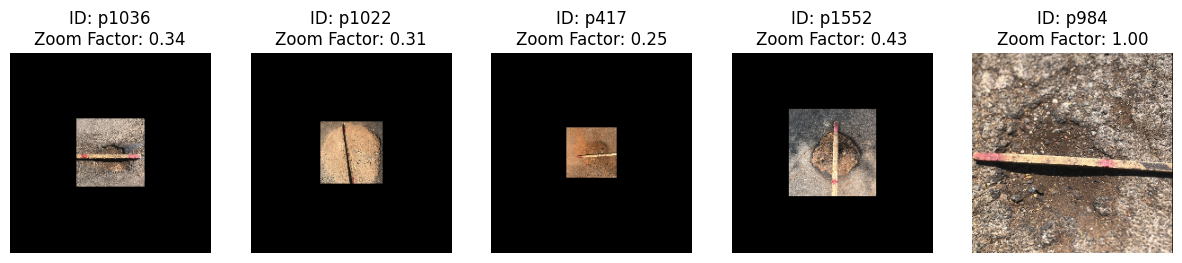

In [ ]:
def load_image(pothole_id, directory, target_size=(224, 224)):
    img_path = os.path.join(directory, f'{pothole_id}.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

def zoom_image(image, zoom_factor):
    h, w = image.shape[:2]

    # Scale the image by the zoom factor
    zoomed_image = cv2.resize(image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    # If zoomed image is larger than the original, crop the center
    if zoom_factor > 1:
        crop_h = (zoomed_image.shape[0] - h) // 2
        crop_w = (zoomed_image.shape[1] - w) // 2
        zoomed_image = zoomed_image[crop_h:crop_h+h, crop_w:crop_w+w]

    # If zoomed image is smaller than the original, pad the edges
    if zoom_factor < 1:
        pad_h = (h - zoomed_image.shape[0]) // 2
        pad_w = (w - zoomed_image.shape[1]) // 2
        zoomed_image = cv2.copyMakeBorder(zoomed_image, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT)

    return zoomed_image

def plot_zoomed_images(labels_df, image_dir, num_images=5):
    # Calculate the minimum mm_to_pixel_ratio across the dataset
    min_mm_to_pixel_ratio = labels_df['mm_to_pixel_ratio'].min()

    # Identify the image with the smallest mm_to_pixel_ratio
    smallest_image_row = labels_df.loc[labels_df['mm_to_pixel_ratio'] == min_mm_to_pixel_ratio].iloc[0:1]

    plt.figure(figsize=(15, 15))

    # Ensure the smallest image is included
    images_to_plot = pd.concat([labels_df.iloc[:num_images - 1], smallest_image_row], ignore_index=True)

    # Plot the images
    for i in range(num_images):
        pothole_id = images_to_plot.iloc[i]['pothole_id']
        mm_to_pixel_ratio = images_to_plot.iloc[i]['mm_to_pixel_ratio']

        # Calculate zoom factor based on the minimum mm_to_pixel_ratio
        zoom_factor = min_mm_to_pixel_ratio / mm_to_pixel_ratio

        # Load and zoom the image
        image = load_image(pothole_id, directory=image_dir)
        zoomed_image = zoom_image(image, zoom_factor)

        # Plot
        plt.subplot(1, num_images, i + 1)
        plt.imshow(zoomed_image)
        plt.title(f'ID: {pothole_id}\nZoom Factor: {zoom_factor:.2f}')
        plt.axis('off')

    plt.show()

# Example usage
plot_zoomed_images(labels_df, '/content/drive/MyDrive/Contrastive Learning/contrastive_learning_images', num_images=5)

In [ ]:
labels_df[labels_df['pothole_id']=='p984']

,pothole_id,mm_to_pixel_ratio,pothole_length,pothole_width,pothole_area_mm2,bags_used,class
40,p984,0.684941,779,771,192658.125111,0.5,1


In [ ]:
labels_df.head(10)

,pothole_id,mm_to_pixel_ratio,pothole_length,pothole_width,pothole_area_mm2,bags_used,class
0,p1036,2.024225,256,174,1.312671e+05,0.50,1
1,p1022,2.233278,769,518,1.802678e+06,2.00,4
2,p417,2.744603,298,218,3.422434e+05,0.50,1
3,p1552,1.583786,490,296,2.085917e+05,0.50,1
4,p1234,4.087254,245,326,8.300200e+05,1.00,2
5,p173,1.580941,220,269,9.155836e+04,0.25,0
6,p1208,2.082177,321,304,1.951369e+05,0.50,1
7,p167,1.329219,367,329,2.398788e+05,0.50,1
8,p1591,1.223896,718,376,2.829228e+05,0.25,0
9,p1585,1.597045,408,378,1.761768e+05,0.25,0


# Triplet Loss

In [ ]:
def load_image(pothole_id, directory=image_dir, target_size=(224, 224)):
    img_path = os.path.join(directory, f'{pothole_id}.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

def standardize_features(labels_df):
    scaler = StandardScaler()
    labels_df[['mm_to_pixel_ratio']] = scaler.fit_transform(
        labels_df[['mm_to_pixel_ratio']]
    )
    return labels_df, scaler

def triplet_generator_hard(labels_df, batch_size=16):
    while True:
        anchors = []
        positives = []
        negatives = []
        scalar_anchor = []
        scalar_pos = []
        scalar_neg = []

        for _ in range(batch_size):
            anchor = labels_df.sample(1).iloc[0]
            positive = labels_df[labels_df['class'] == anchor['class']].sample(1).iloc[0]
            # Hard negative mining: choose the most similar class as the negative
            negative_class = labels_df[labels_df['class'] != anchor['class']].sample(1)['class'].iloc[0]
            negative = labels_df[labels_df['class'] == negative_class].sample(1).iloc[0]

            anchors.append(load_image(anchor['pothole_id']))
            positives.append(load_image(positive['pothole_id']))
            negatives.append(load_image(negative['pothole_id']))

            scalar_anchor.append([anchor['mm_to_pixel_ratio']])
            scalar_pos.append([positive['mm_to_pixel_ratio']])
            scalar_neg.append([negative['mm_to_pixel_ratio']])

        yield (
            {
                'input_anchor_image': np.array(anchors),
                'input_pos_image': np.array(positives),
                'input_neg_image': np.array(negatives),
                'input_scalar_anchor': np.array(scalar_anchor),
                'input_scalar_pos': np.array(scalar_pos),
                'input_scalar_neg': np.array(scalar_neg)
            },
            np.zeros((batch_size, 3))  # Dummy target for the triplet loss
        )

def triplet_dataset(labels_df, batch_size=16):
    return tf.data.Dataset.from_generator(
        lambda: triplet_generator_hard(labels_df, batch_size),
        output_signature=(
            {
                'input_anchor_image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                'input_pos_image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                'input_neg_image': tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
                'input_scalar_anchor': tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
                'input_scalar_pos': tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
                'input_scalar_neg': tf.TensorSpec(shape=(None, 1), dtype=tf.float32),
            },
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)  # Dummy target
        )
    )

def make_simplified_embedding_model(input_shape=(224, 224, 3), scalar_shape=(1,), embedding_dim=64, dropout_rate=0.2):
    inp = Input(shape=input_shape, name='input_image')

    # Fewer filters and layers
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_layer_1')(inp)
    c1 = MaxPooling2D((2, 2), name='pool_layer_1')(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_layer_2')(c1)
    c2 = MaxPooling2D((2, 2), name='pool_layer_2')(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_layer_3')(c2)
    c3 = MaxPooling2D((2, 2), name='pool_layer_3')(c3)

    f1 = GlobalAveragePooling2D(name='global_avg_pool')(c3)

    scalar_input = Input(shape=scalar_shape, name='input_scalar')
    scalar_dense = Dense(32, activation='relu')(scalar_input)
    scalar_dense = Dropout(dropout_rate)(scalar_dense)

    combined = Concatenate(name='concat_image_scalar')([f1, scalar_dense])

    embedding = Dense(embedding_dim, name='embedding_layer')(combined)
    embedding = BatchNormalization(name='embedding_batch_norm')(embedding)

    return Model(inputs=[inp, scalar_input], outputs=embedding, name='simplified_embedding_model')

# Use the simplified embedding model in the triplet model
embedding_model = make_simplified_embedding_model()

def triplet_loss(margin=1.0):
    def _triplet_loss(y_true, y_pred):
        anchor = y_pred[:, 0, :]
        positive = y_pred[:, 1, :]
        negative = y_pred[:, 2, :]

        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

        loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
        return loss
    return _triplet_loss

# Inputs
input_anchor_image = Input(shape=(224, 224, 3), name='input_anchor_image')
input_pos_image = Input(shape=(224, 224, 3), name='input_pos_image')
input_neg_image = Input(shape=(224, 224, 3), name='input_neg_image')

input_scalar_anchor = Input(shape=(1,), name='input_scalar_anchor')
input_scalar_pos = Input(shape=(1,), name='input_scalar_pos')
input_scalar_neg = Input(shape=(1,), name='input_scalar_neg')

# Generate embeddings
embedding_anchor = embedding_model([input_anchor_image, input_scalar_anchor])
embedding_positive = embedding_model([input_pos_image, input_scalar_pos])
embedding_negative = embedding_model([input_neg_image, input_scalar_neg])

# Concatenate embeddings into one tensor along a new axis using Lambda layer
merged_embeddings = Lambda(lambda x: tf.stack(x, axis=1))([embedding_anchor, embedding_positive, embedding_negative])

# Model to output merged embeddings for triplets
triplet_model = Model(
    inputs=[input_anchor_image, input_pos_image, input_neg_image, input_scalar_anchor, input_scalar_pos, input_scalar_neg],
    outputs=merged_embeddings
)

# Compile the model
triplet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=triplet_loss(margin=1.0))

# Train the model for 30 epochs
history = triplet_model.fit(
    triplet_dataset(labels_df, batch_size=16),
    steps_per_epoch=100,
    epochs=30,
    verbose=1
)

# Save the embedding model after training
embedding_model.save('/content/drive/MyDrive/Contrastive Learning/triplet_embedding_model.keras')

Epoch 1/30
  1/100 ━━━━━━━━━━━━━━━━━━━━ 55:55 34s/step - loss: 31.8066

KeyboardInterrupt: 

In [ ]:
base_network.save('/content/drive/MyDrive/Contrastive Learning/triplet_embedding_model.keras')

In [2]:
import numpy as np
import os
import tensorflow as tf

# Function to load and preprocess images
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize the image
    return img

# Load images and preprocess them, then save to disk
def preprocess_and_save_images(labels_df, image_dir, save_dir, target_size=(224, 224)):
    images = []
    labels = []

    for i, pothole_id in enumerate(labels_df['pothole_id']):
        img_path = os.path.join(image_dir, f'{pothole_id}.jpg')
        img = load_and_preprocess_image(img_path, target_size)
        images.append(img)

        # Get the corresponding label (bags used)
        labels.append(labels_df[labels_df['pothole_id'] == pothole_id]['bags_used'].values[0])

    images = np.array(images)
    labels = np.array(labels)

    # Save the arrays to disk
    np.save(os.path.join(save_dir, 'images.npy'), images)
    np.save(os.path.join(save_dir, 'labels.npy'), labels)

    print(f"Preprocessed images and labels saved to {save_dir}")

# Directory to save the preprocessed data
save_dir = '/content/drive/MyDrive/Contrastive Learning/preprocessed_data'
os.makedirs(save_dir, exist_ok=True)

# Preprocess images and labels and save them
preprocess_and_save_images(labels_df, image_dir, save_dir)

KeyboardInterrupt: 

In [2]:
save_dir = '/content/drive/MyDrive/Contrastive Learning/preprocessed_data'
# Load preprocessed images and labels
images = np.load(os.path.join(save_dir, 'images.npy'))
labels = np.load(os.path.join(save_dir, 'labels.npy'))

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Data loaded and split into training and validation sets.")

Data loaded and split into training and validation sets.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,     # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2, # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,# Randomly shift images vertically by up to 20%
    shear_range=0.2,       # Shear transformation
    zoom_range=0.2,        # Randomly zoom in by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'    # Fill in new pixels with the nearest pixels
)

# Use the generator to augment images during training
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)

def build_super_cnn_model(input_shape=(224, 224, 3)):
    input_image = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_image)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Second Convolutional Block
    x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Third Convolutional Block
    x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Fourth Convolutional Block
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layers
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)

    # Output Layer
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=input_image, outputs=output)

    return model

# Build the super model
model = build_super_cnn_model()

# Compile the model with MSE loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='mean_squared_error',
              metrics=['mae'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Modelling/best_model_with_augmentation.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min')

callbacks = [early_stopping, model_checkpoint]

# Train the model using the augmented data generator
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 8,  # Adjust according to batch size
    validation_data=(X_val, y_val),
    epochs=80,
    callbacks=callbacks
)

# Save the final model after training
model.save('/content/drive/MyDrive/Modelling/final_model_with_augmentation.keras')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 15,533,569 (59.26 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 546ms/step - loss: 3.7994 - mae: 1.1521 - val_loss: 1.3502 - val_mae: 0.7222 - learning_rate: 1.0000e-05
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 1.1540 - mae: 0.7269 - val_loss: 1.4584 - val_mae: 0.7899 - learning_rate: 1.0000e-05
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 1.8100 - mae: 0.7379 - val_loss: 1.5163 - val_mae: 0.8190 - learning_rate: 1.0000e-05
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 1.9931 - mae: 0.6656 - val_loss: 1.3386 - val_mae: 0.7095 - learning_rate: 1.0000e-05
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 232ms/step - loss: 1.9149 - mae: 0.7053 - val_loss: 1.0949 - val_mae: 0.5448 - learning_rate: 1.0000e-05
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - loss: 0.9478 - mae: 0.6295 - val_loss: 1.0186 - val_mae: 0.4929 - learning_rate: 1.0000e-05
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 1.5361 - mae: 0.6374 - val_loss: 0.9241 - val_mae: 0.4490

In [7]:
model.save('/content/drive/MyDrive/Modelling/final_model.keras')

In [6]:
model_path = '/content/drive/MyDrive/Modelling/best_model_continued.keras'  # Adjust the path as needed
model = load_model(model_path)

# Compile the model if needed (shouldn't be necessary if you're resuming training)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error',
              metrics=['mae'])

# Define the callbacks again
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Modelling/best_model_continued.keras',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   mode='min')

callbacks = [early_stopping, model_checkpoint]

# Continue training for additional epochs
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=40,  # Continue training for 40 more epochs
                    batch_size=8,
                    callbacks=callbacks)

# Save the final model again after continued training
model.save('/content/drive/MyDrive/Modelling/final_model_continued.keras')

print("Continued model training complete and saved!")

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 1.6704 - mae: 0.5856 - val_loss: 0.9386 - val_mae: 0.5163
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 1.6130 - mae: 0.5670 - val_loss: 0.9357 - val_mae: 0.5133
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.6680 - mae: 0.6347 - val_loss: 0.9420 - val_mae: 0.4800
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.6344 - mae: 0.5897 - val_loss: 0.9338 - val_mae: 0.5295
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.3737 - mae: 0.5716 - val_loss: 0.9601 - val_mae: 0.5958
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7247 - mae: 0.5171 - val_loss: 0.9766 - val_mae: 0.6224
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.0860 - mae: 0.6724 - val_loss: 0.9287 - val_mae: 0.5086
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.5552 - mae: 0.6596 - val_loss: 0.9272 - val_mae: 0.5140
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.244